In [1]:
import os
import numpy as np
from scipy import stats
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
%matplotlib inline

In [2]:
##数据说明：本数据是一份汽车贷款违约数据
##名称---中文含义
##application_id---申请者ID
##account_number---帐户号
##bad_ind---是否违约
##vehicle_year---汽车购买时间
##vehicle_make---汽车制造商
##bankruptcy_ind---曾经破产标识
##tot_derog---五年内信用不良事件数量(比如手机欠费消号)
##tot_tr---全部帐户数量
##age_oldest_tr---最久账号存续时间(月)
##tot_open_tr---在使用帐户数量
##tot_rev_tr---在使用可循环贷款帐户数量(比如信用卡)
##tot_rev_debt---在使用可循环贷款帐户余额(比如信用卡欠款)
##tot_rev_line---可循环贷款帐户限额(信用卡授权额度)
##rev_util---可循环贷款帐户使用比例(余额/限额)
##fico_score---FICO打分
##purch_price---汽车购买金额(元)
##msrp---建议售价
##down_pyt---分期付款的首次交款
##loan_term---贷款期限(月)
##loan_amt---贷款金额
##ltv---贷款金额/建议售价*100
##tot_income---月均收入(元)
##veh_mileage---行使历程(Mile)
##used_ind---是否二手车
##weight---样本权重


## 导入数据和数据清洗

In [3]:
accepts = pd.read_csv('脚本/accepts.csv').dropna()

In [4]:
accepts.shape

(4105, 25)

In [5]:
accepts.head()

,application_id,account_number,bad_ind,vehicle_year,vehicle_make,bankruptcy_ind,tot_derog,tot_tr,age_oldest_tr,tot_open_tr,...,purch_price,msrp,down_pyt,loan_term,loan_amt,ltv,tot_income,veh_mileage,used_ind,weight
0,2314049,11613,1,1998.0,FORD,N,7.0,9.0,64.0,2.0,...,17200.00,17350.0,0.00,36,17200.00,99.0,6550.00,24000.0,1,1.00
1,63539,13449,0,2000.0,DAEWOO,N,0.0,21.0,240.0,11.0,...,19588.54,19788.0,683.54,60,19588.54,99.0,4666.67,22.0,0,4.75
3,8725187,15359,1,1997.0,FORD,N,3.0,10.0,35.0,5.0,...,12999.00,12100.0,3099.00,60,10800.00,118.0,1500.00,10000.0,1,1.00
4,4275127,15812,0,2000.0,TOYOTA,N,0.0,10.0,104.0,2.0,...,26328.04,22024.0,0.00,60,26328.04,122.0,4144.00,14.0,0,4.75
5,8712513,16979,0,2000.0,DODGE,Y,2.0,15.0,136.0,4.0,...,26272.72,26375.0,0.00,36,26272.72,100.0,5400.00,1.0,0,4.75


In [6]:
accepts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4105 entries, 0 to 5844
Data columns (total 25 columns):
application_id    4105 non-null int64
account_number    4105 non-null int64
bad_ind           4105 non-null int64
vehicle_year      4105 non-null float64
vehicle_make      4105 non-null object
bankruptcy_ind    4105 non-null object
tot_derog         4105 non-null float64
tot_tr            4105 non-null float64
age_oldest_tr     4105 non-null float64
tot_open_tr       4105 non-null float64
tot_rev_tr        4105 non-null float64
tot_rev_debt      4105 non-null float64
tot_rev_line      4105 non-null float64
rev_util          4105 non-null int64
fico_score        4105 non-null float64
purch_price       4105 non-null float64
msrp              4105 non-null float64
down_pyt          4105 non-null float64
loan_term         4105 non-null int64
loan_amt          4105 non-null float64
ltv               4105 non-null float64
tot_income        4105 non-null float64
veh_mileage       4105 no

## 衍生变量

In [7]:
def divMy(x,y):
    import numpy as np
    if x==np.nan or y==np.nan:
        return np.nan
    elif y==0:
        return -1
    else:
        return x/y

In [8]:
##历史负债收入比:tot_rev_line/tot_income
accepts["dti_hist"]=accepts[["tot_rev_line","tot_income"]].apply(lambda x:divMy(x[0],x[1]),axis = 1)
##本次新增负债收入比:loan_amt/tot_income
accepts["dti_mew"]=accepts[["loan_amt","tot_income"]].apply(lambda x:divMy(x[0],x[1]),axis = 1)
##本次贷款首付比例:down_pyt/loan_amt
accepts["fta"]=accepts[["down_pyt","loan_amt"]].apply(lambda x:divMy(x[0],x[1]),axis = 1)
##新增债务比:loan_amt/tot_rev_debt
accepts["nth"]=accepts[["loan_amt","tot_rev_debt"]].apply(lambda x:divMy(x[0],x[1]),axis = 1)
##新增债务额度比:loan_amt/tot_rev_line
accepts["nta"]=accepts[["loan_amt","tot_rev_line"]].apply(lambda x:divMy(x[0],x[1]),axis = 1)

In [9]:
accepts.head()

,application_id,account_number,bad_ind,vehicle_year,vehicle_make,bankruptcy_ind,tot_derog,tot_tr,age_oldest_tr,tot_open_tr,...,ltv,tot_income,veh_mileage,used_ind,weight,dti_hist,dti_mew,fta,nth,nta
0,2314049,11613,1,1998.0,FORD,N,7.0,9.0,64.0,2.0,...,99.0,6550.00,24000.0,1,1.00,0.076336,2.625954,0.000000,33.992095,34.400000
1,63539,13449,0,2000.0,DAEWOO,N,0.0,21.0,240.0,11.0,...,99.0,4666.67,22.0,0,4.75,12.265920,4.197541,0.034895,0.566061,0.342212
3,8725187,15359,1,1997.0,FORD,N,3.0,10.0,35.0,5.0,...,118.0,1500.00,10000.0,1,1.00,3.964000,7.200000,0.286944,2.687236,1.816347
4,4275127,15812,0,2000.0,TOYOTA,N,0.0,10.0,104.0,2.0,...,122.0,4144.00,14.0,0,4.75,0.434363,6.353292,0.000000,-1.000000,14.626689
5,8712513,16979,0,2000.0,DODGE,Y,2.0,15.0,136.0,4.0,...,100.0,5400.00,1.0,0,4.75,1.064259,4.865319,0.000000,7.196034,4.571554


##  分类变量的相关关系

In [10]:
cross_table = pd.crosstab(accepts.used_ind,accepts.bad_ind, margins=True)
#cross_table = pd.crosstab(accepts.bankruptcy_ind,accepts.bad_ind, margins=True)

In [11]:
cross_table

bad_ind,0,1,All
used_ind,,,
0,1457,306,1763
1,1862,480,2342
All,3319,786,4105


In [12]:
cross_table.apply(lambda x:x/x[-1],axis=1)

bad_ind,0,1,All
used_ind,,,
0,0.826432,0.173568,1.0
1,0.795047,0.204953,1.0
All,0.808526,0.191474,1.0


In [13]:
stats.chi2_contingency(cross_table.iloc[:2, :2])

(6.198781643195083,
 0.012783828178893867,
 1,
 array([[1425.4316687,  337.5683313],
        [1893.5683313,  448.4316687]]))

In [14]:
print('''chisq = %6.4f 
p-value = %6.4f
dof = %i 
expected_freq = %s'''  %stats.chi2_contingency(cross_table.iloc[:2, :2]))

chisq = 6.1988 
p-value = 0.0128
dof = 1 
expected_freq = [[1425.4316687  337.5683313]
 [1893.5683313  448.4316687]]


可以看出是否二手车和违约相关性比较显著

## 逻辑回归

### 一元逻辑回归

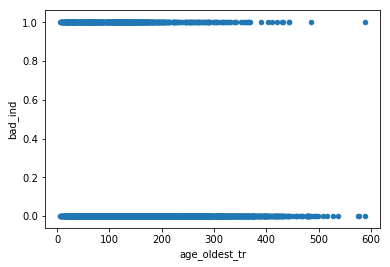

In [15]:
accepts.plot(x='age_oldest_tr', y='bad_ind', kind='scatter')

In [16]:
# •随机抽样，建立训练集与测试集
train = accepts.sample(frac=0.7, random_state=1234).copy()
test = accepts[~ accepts.index.isin(train.index)].copy()
print(' 训练集样本量: %i \n 测试集样本量: %i' %(len(train), len(test)))

 训练集样本量: 2874 
 测试集样本量: 1231


In [17]:
lg = smf.glm('bad_ind ~ age_oldest_tr', data=train, 
             family=sm.families.Binomial(sm.families.links.logit)).fit()
lg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                bad_ind   No. Observations:                 2874
Model:                            GLM   Df Residuals:                     2872
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1347.1
Date:                Mon, 25 Jun 2018   Deviance:                       2694.1
Time:                        05:35:29   Pearson chi2:                 3.00e+03
No. Iterations:                     5   Covariance Type:             nonrobust
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.5024      0.092     -5.457      0.000      -0.683      -0.322
age_oldest_tr    -0.0063      0.001    -10.510      0.000      -0.008      -0.005
=================================================================================
"""

In [18]:
# 预测
train['proba'] = lg.predict(train)
test['proba'] = lg.predict(test)
test['proba'].head(10)

4     0.238307
6     0.065840
10    0.148619
11    0.267025
13    0.283468
16    0.277072
20    0.051232
22    0.236012
35    0.147021
43    0.052479
Name: proba, dtype: float64

In [49]:
## 模型评估 
# 设定阈值
test['prediction'] = (test['proba'] > 0.3).astype('int')

In [37]:
# 混淆矩阵
pd.crosstab(test.bad_ind, test.prediction, margins=True)

prediction,0,1,All
bad_ind,,,
0,993,9,1002
1,222,7,229
All,1215,16,1231


In [50]:
# 计算准确率
acc = sum(test['prediction'] == test['bad_ind']) /len(test)
print('The accurancy is %.2f' %acc)

The accurancy is 0.77


In [32]:
for i in np.arange(0.02, 0.3, 0.02):
    prediction = (test['proba'] > i).astype('int')
    confusion_matrix = pd.crosstab(prediction,test.bad_ind,
                                   margins = True)
    precision = confusion_matrix.iloc[0, 0] /confusion_matrix.iloc[-1, 0]
    recall = confusion_matrix.iloc[0, 0] / confusion_matrix.iloc[0, -1]
    Specificity = confusion_matrix.iloc[1, 1] /confusion_matrix.iloc[1,-1]
    f1_score = 2 * (precision * recall) / (precision + recall)
    print('threshold: %s, precision: %.2f, recall:%.2f ,Specificity:%.2f , f1_score:%.2f'%\
          (i, precision, recall, Specificity,f1_score))

threshold: 0.02, precision: 0.00, recall:1.00 ,Specificity:0.19 , f1_score:0.01
threshold: 0.04, precision: 0.02, recall:0.94 ,Specificity:0.19 , f1_score:0.03
threshold: 0.06, precision: 0.05, recall:0.91 ,Specificity:0.19 , f1_score:0.10
threshold: 0.08, precision: 0.09, recall:0.89 ,Specificity:0.19 , f1_score:0.16
threshold: 0.1, precision: 0.14, recall:0.88 ,Specificity:0.20 , f1_score:0.25
threshold: 0.12000000000000001, precision: 0.22, recall:0.89 ,Specificity:0.20 , f1_score:0.35
threshold: 0.13999999999999999, precision: 0.29, recall:0.89 ,Specificity:0.21 , f1_score:0.43
threshold: 0.16, precision: 0.38, recall:0.88 ,Specificity:0.22 , f1_score:0.53
threshold: 0.18, precision: 0.48, recall:0.86 ,Specificity:0.23 , f1_score:0.62
threshold: 0.19999999999999998, precision: 0.58, recall:0.86 ,Specificity:0.24 , f1_score:0.69
threshold: 0.22, precision: 0.69, recall:0.85 ,Specificity:0.26 , f1_score:0.76
threshold: 0.24, precision: 0.76, recall:0.84 ,Specificity:0.26 , f1_score:0

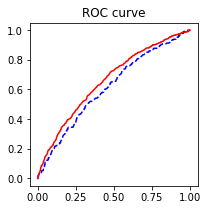

AUC = 0.6136


In [51]:
# - 绘制ROC曲线
import sklearn.metrics as metrics
fpr_test, tpr_test, th_test = metrics.roc_curve(test.bad_ind, test.proba)
fpr_train, tpr_train, th_train = metrics.roc_curve(train.bad_ind, train.proba)
plt.figure(figsize=[3, 3])
plt.plot(fpr_test, tpr_test, 'b--')
plt.plot(fpr_train, tpr_train, 'r-')
plt.title('ROC curve')
plt.show()
print('AUC = %.4f' %metrics.auc(fpr_test, tpr_test))

In [52]:
# 包含分类预测变量的逻辑回归
#%%
formula = '''bad_ind ~ C(used_ind)'''
lg_m = smf.glm(formula=formula, data=train, 
             family=sm.families.Binomial(sm.families.links.logit)).fit()
lg_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                bad_ind   No. Observations:                 2874
Model:                            GLM   Df Residuals:                     2872
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1411.6
Date:                Mon, 25 Jun 2018   Deviance:                       2823.2
Time:                        06:49:21   Pearson chi2:                 2.87e+03
No. Iterations:                     4   Covariance Type:             nonrobust
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.5247      0.075    -20.447      0.000      -1.671      -1.379
C(used_ind)[T.1]     0.1692      0.096      1.756      0.079      -0.020       0.358
====================================================================================
"""

In [54]:
X=accepts.drop('bad_ind',axis=1)

In [57]:
y=accepts.bad_ind

In [65]:
model=DecisionTreeClassifier()

In [68]:
model.fit(X,y)

ValueError: could not convert string to float: 'N'